In [1]:
import pandas as pd
import numpy as np
import geojson
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, Polygon, MultiPolygon

#### Utiles

In [2]:
state_abreviations = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", "HI", "ID", 
    "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", 
    "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", 
    "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", 
    "WI", "WY"
]

state_dictionary = {
    "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas", 
    "CA": "California", "CO": "Colorado", "CT": "Connecticut", "DC":"District of Columbia","DE": "Delaware", 
    "FL": "Florida", "GA": "Georgia", "HI": "Hawaii", "ID": "Idaho", "IL": "Illinois", 
    "IN": "Indiana", "IA": "Iowa", "KS": "Kansas", "KY": "Kentucky", "LA": "Louisiana", 
    "ME": "Maine", "MD": "Maryland", "MA": "Massachusetts", "MI": "Michigan", 
    "MN": "Minnesota", "MS": "Mississippi", "MO": "Missouri", "MT": "Montana", 
    "NE": "Nebraska", "NV": "Nevada", "NH": "New Hampshire", "NJ": "New Jersey", 
    "NM": "New Mexico", "NY": "New York", "NC": "North Carolina", "ND": "North Dakota", 
    "OH": "Ohio", "OK": "Oklahoma", "OR": "Oregon", "PA": "Pennsylvania", 
    "RI": "Rhode Island", "SC": "South Carolina", "SD": "South Dakota", "TN": "Tennessee", 
    "TX": "Texas", "UT": "Utah", "VT": "Vermont", "VA": "Virginia", "WA": "Washington", 
    "WV": "West Virginia", "WI": "Wisconsin", "WY": "Wyoming"
}

state_dictionary_inv = dict(zip(state_dictionary.values(), state_dictionary.keys()))

state_index = pd.read_csv('2014_usa_states.csv', dtype={'Rank': 'int'}, index_col='Rank')[['State']]['State'].to_dict()

with open('us-states.json', 'r') as f:
    data_geo_1 = geojson.load(f)
    
def get_state_1(lat, lon):
    # print([lat, lon])
    for i in range(len(data_geo_1['features'])):
        try:
            coordinates = data_geo_1['features'][i]['geometry']['coordinates'][0] 
            polygon = Polygon(coordinates)

            if polygon.contains(Point(lon, lat)):
                return state_dictionary_inv[data_geo_1['features'][i].properties['name']]
        except:
            pass
    return None

with open('geojson-counties-fips.json', 'r') as f:
    data_geo_2 = geojson.load(f)
    
def get_state_2(lat, lon):
    for feature in data_geo_2['features']:
        try:
            geometry_type = feature['geometry']['type']
            
            if geometry_type == 'Polygon':
                coordinates = feature['geometry']['coordinates'][0]
                polygon = Polygon(coordinates)
                if polygon.contains(Point(lon, lat)):
                    return state_dictionary_inv[state_index[int(feature['properties']['STATE'])]]
                
            elif geometry_type == 'MultiPolygon':
                for polygon_coords in feature['geometry']['coordinates']:
                    polygon = Polygon(polygon_coords[0])
                    if polygon.contains(Point(lon, lat)):
                        return state_dictionary_inv[state_index[int(feature['properties']['STATE'])]]
                
        except (KeyError, IndexError):
            return None
    
    return None

def get_state_ab(address):
    try:
        state = address.split(', ')[-1].split(' ')[0]
        if state in state_abreviations:
            return state
        else:
            return np.nan
    except:
        return np.nan
    

Leer archivos parquet

In [3]:
df_sitios_google = pd.read_parquet(r'Generated\Google\metada_sitios.parquet')

In [4]:
df_sitios_google['state_ab'] = df_sitios_google['address'].apply(lambda ad: get_state_ab(ad) )

In [5]:
df_sitios_google['state_ab'].isna().sum()

13647

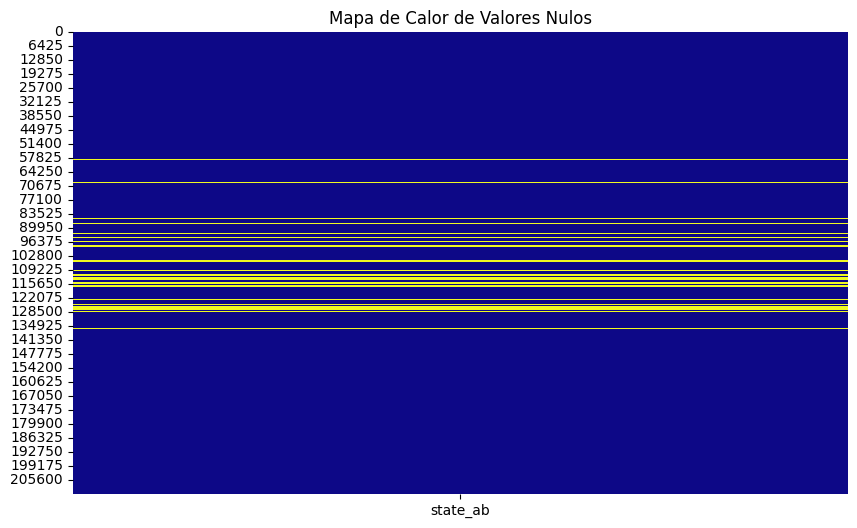

In [6]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_sitios_google[['state_ab']].isnull(), cmap='plasma', cbar=False)
plt.title('Mapa de Calor de Valores Nulos')
plt.show()

In [7]:
# Filter rows where 'state_ab' is null and fill them based on latitude and longitude
null_state_rows = df_sitios_google['state_ab'].isnull()
df_sitios_google.loc[null_state_rows, 'state_ab'] = df_sitios_google[null_state_rows].apply(lambda row: get_state_1(row['latitude'], row['longitude']), axis=1)


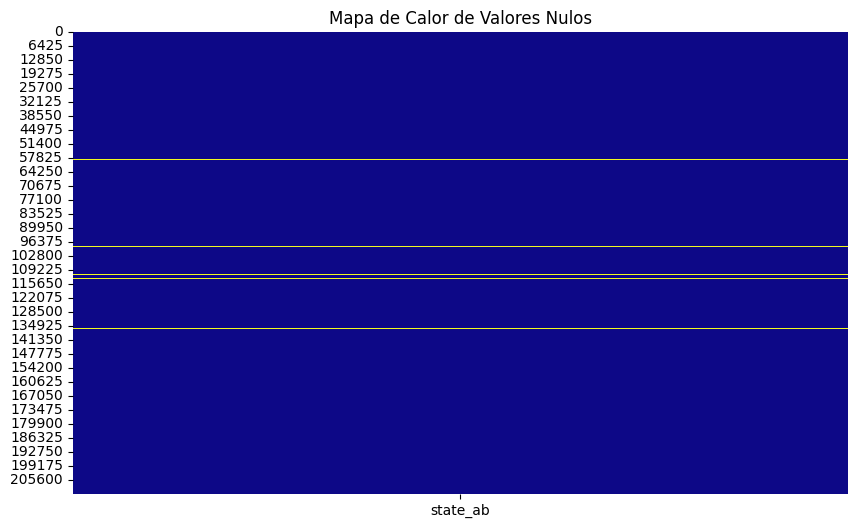

In [8]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_sitios_google[['state_ab']].isnull(), cmap='plasma', cbar=False)
plt.title('Mapa de Calor de Valores Nulos')
plt.show()

In [9]:
null_state_rows = df_sitios_google['state_ab'].isnull()
df_sitios_google.loc[null_state_rows, 'state_ab'] = df_sitios_google[null_state_rows].apply(lambda row: get_state_2(row['latitude'], row['longitude']), axis=1)

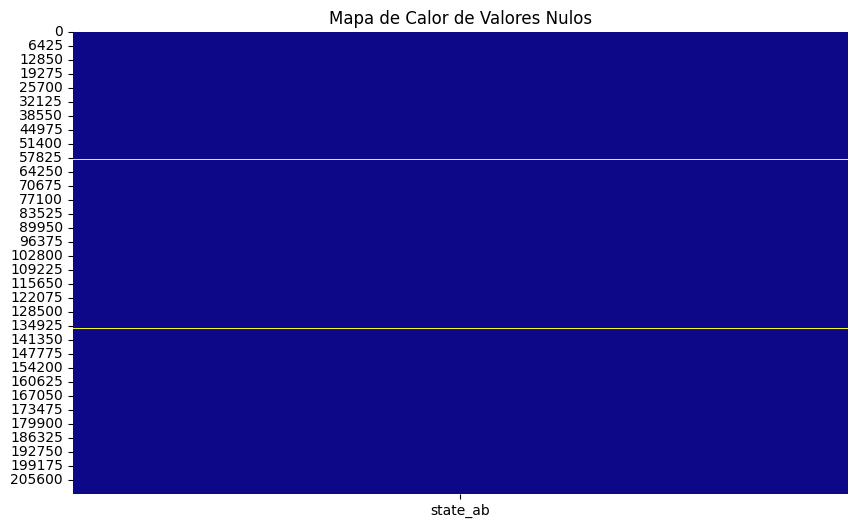

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_sitios_google[['state_ab']].isnull(), cmap='plasma', cbar=False)
plt.title('Mapa de Calor de Valores Nulos')
plt.show()

In [11]:
df_sitios_google[df_sitios_google['state_ab'].isnull()].loc[209, 'url']

'https://www.google.com/maps/place//data=!4m2!3m1!1s0x808fcb01ac33a5a1:0x3395a179c5d59ea5?authuser=-1&hl=en&gl=us'

In [12]:
df_sitios_google[df_sitios_google['state_ab'].isnull()].head(3)

,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url,state_ab
209,The Feast India Company,None,0x808fcb01ac33a5a1:0x3395a179c5d59ea5,None,45.597767,-127.269699,"[Delivery Restaurant, Service establishment]",5.0,2,None,"[[Wednesday, 12–9PM], [Thursday, 12–9PM], [Fri...",None,Open ⋅ Closes 9PM,[0x808e353c3992eeed:0x8de09719e4991639],https://www.google.com/maps/place//data=!4m2!3...,None
242,Antojitos Criollos Puertoriqueno,None,0x89c64cb249abef29:0x935be44e4112e10a,None,45.598021,-127.269639,"[Delivery Restaurant, Service establishment]",4.6,33,None,"[[Wednesday, Closed], [Thursday, Closed], [Fri...","{'Accessibility': None, 'Amenities': None, 'At...",Closed ⋅ Opens 9AM Sun,"[0x89c64cbc41920e77:0x4743207e64e6efe8, 0x89c6...",https://www.google.com/maps/place//data=!4m2!3...,None
1270,The Feast India Company,None,0x808fcb01ac33a5a1:0x3395a179c5d59ea5,None,45.597767,-127.269699,"[Delivery Restaurant, Service establishment]",5.0,2,None,"[[Wednesday, 12–9PM], [Thursday, 12–9PM], [Fri...",None,Open ⋅ Closes 9PM,[0x808e353c3992eeed:0x8de09719e4991639],https://www.google.com/maps/place//data=!4m2!3...,None


In [13]:
print(get_state_2(32.355214, -86.215974))

AL
